### imports

In [1]:
import NanowireMesh as nwm
import pdb
import pandas as pd
import numpy as np
from scipy import stats, interpolate, optimize
from copy import deepcopy
from tqdm import tqdm
import os
import seaborn as sns
from matplotlib import pyplot as plt
import NanowireOptics as nwo
import importlib as il
il.reload(nwo)

<module 'NanowireOptics' from '/Users/adamtrebach/Documents/Research/TPV/Nanowires/NanowireOptics.py'>

### initializing and collecting data from simulations

In [2]:
transparencyParams = dict(wavelength = 550E-9,
                        n_silver = 0.055 + 3.32j,
                        n_air = 1.00027784
)
transparencyParams['mr'] = transparencyParams['n_silver'] / transparencyParams['n_air']

# refractive index of silver calculated from Physical Properties and Data of Optical Materials 2007 (wakaki, shibuya, kudo)
# refractive index of air calculated from Refractive index of air: new equations for the visible and near infrared, 1996, (Ciddor) and  https://refractiveindex.info/?shelf=other&book=air&page=Ciddor

# allowing for customization without changing this script or the submit script
resultsFolder = 'Results/bc_paper_node_removal_data_v4_019' #sys.argv[1]
if resultsFolder[-1] != '/':
    resultsFolder = resultsFolder + '/'
runtimeOptionsDf = pd.read_csv(resultsFolder + 'runtimeOptions.csv')

# columns
runtimeOptions = dict(zip(runtimeOptionsDf.iloc[:,0], runtimeOptionsDf.iloc[:,1]))
for key,val in runtimeOptions.items(): # converting strings into other data types if possible
    if val in ['True', 'False']:
        runtimeOptions[key] = val == 'True'
    else:
        try:
            runtimeOptions[key] = float(val)
        except ValueError:
            pass # this is not a number

srcNetworkFolder = runtimeOptions['srcNetworkFolder']

legendLabels = {
    'betweenness_centrality' : r"$C_B$",
    'unweighted_betweenness_centrality' : r"$C_\text{uw}$",
    'percolation_centrality' : r"$C_\text{perc}$",
    'current_weighted_centrality' : r"$C_\text{curr}$",
    'electrode_centrality' : r"$C_\text{elec}$",
    'power_weighted_centrality' : r"$C_\text{pow}$",
    'Percolation Theory' : 'Percolation Theory',
    'random_cleaned' : "RAND",
    'random' : 'RAND UNCLEANED',
    'opt' : 'Theoretical Optimum'
}

plotColors = {
    'betweenness_centrality' : 'blue',
    'percolation_centrality' : 'green',
    'current_weighted_centrality' : 'red',
    'electrode_centrality' : 'violet',
    'power_weighted_centrality' : 'black',
    'Percolation Theory' : 'black',
    'random_cleaned' : 'black',
    'random' : 'black',
    'opt' : 'black',
    'unweighted_betweenness_centrality' : 'darkorange'
}


# setting data series to skip
#skips = ['random_cleaned',
#	'random',
#	'unweighted_betweenness_centrality',
#	'power_weighted_centrality']
nonSkips = ['betweenness_centrality',
            'Percolation Theory',
            'opt',
            'electrode_centrality',
            'percolation_centrality',
            'current_weighted_centrality'
            ]
skips = [key for key in legendLabels.keys() if key not in nonSkips]

# deleting the skips from legendLabels so we can dictate the order or plot
# by changing the order of entries in legendLabels
for key in skips:
    del legendLabels[key]

print('done')


done


In [3]:


imgFormat = 'png'
# note this gets the effective perc multiple
def get_perc_multiple(g):
    assert g.width == g.height, "Width and height are not the same"
    lTot = sum([g.nodes[node]['length'] for node in g if node not in [g.topElectrode, g.bottomElectrode]])
    l = g.nwLength
    Ls = g.width
    return lTot * l / (5.63726 * Ls**2 + l * Ls + 5.5 * l**2)


def effective_perc_multiple_to_density(percMultiple, nwLength, height, width):
    assert height == width, "Height and width must be equal"
    nc_eff = 5.63726 / nwLength**2 + 1 / (nwLength * height) + 5.5 / (height**2)
    n_s = percMultiple * nc_eff
    return n_s

def fom(resistance, transparency):
    return 188.5 / (resistance * (transparency**(-1/2) - 1))


params = {'width' : None,
          'height' : None,
          'nwLength' : None,
          'rcMean' : None,
          'rcSD' : None,
          'buffer' : 1,
          'percMultiple' : None,
          'nwDiam' : None,
          'buffer' : 2,
          'initialTemp' : 298.15,
          'addInternalResistance' : None}

# setting the params that are specific in runtimeOptions.csv
for key in params.keys():
    if params[key] == None:
        params[key] = runtimeOptions[key]

if 'evolveData.csv' in os.listdir(resultsFolder):
    evolveData = pd.read_csv(filepath_or_buffer = resultsFolder + 'evolveData.csv',
                             index_col = False)

if 'initialData.csv' in os.listdir(resultsFolder):
    initialData = pd.read_csv(resultsFolder + 'initialData.csv')
else:
    initialData = []
    for fileName in os.listdir(resultsFolder + 'bc_paper_network_generator_001/'):
        if fileName[-2:] == '.p':
            # file names are like task_01_trial_05_initial.p
            # so if we split by '_' then the task number will be right after task in the list from the split
            fileNameSplit = fileName.split('_')
            task = int( fileNameSplit[ fileNameSplit.index('task') + 1] )
            trial = int( fileNameSplit[ fileNameSplit.index('trial') + 1] )
            row = {'task' : task,
                   'trial' : trial}
            g = nwm.NanowireMesh(inPickle = resultsFolder + 'bc_paper_network_generator_001/' + fileName)
            row['resistance'] = g.sheetResistance
            row['percMultiple'] = get_perc_multiple(g)
            # here we make a row with the same date (task, trial, resistance, percMultiple) for each centrality.
            # this way when we merge this into evolveData we get the complete trajectory including the starting point
            # for each unique combo of task, trial, centrality
            for centrality in pd.unique(evolveData.centrality):
                row['centrality'] = centrality
                initialData.append(deepcopy(row))
    initialData = pd.DataFrame(initialData)
    initialData.to_csv(resultsFolder + 'initialData.csv',
                       index = False)

print('completed')

completed


### generating theoretical data as predicted percolation theory

In [4]:

# getting theoretical data predicted by percolation theory
if 'theoryData.csv' in os.listdir(resultsFolder):
    theoryData = pd.read_csv(resultsFolder + 'theoryData.csv')
else:
    group = evolveData.groupby(by = ['task', 'trial'])
    alpha0 = initialData.percMultiple.mean() # alpha0 should be the mean starting density
    #	alpha0 = group.aggregate(func = 'max').percMultiple.mean()	 # finding mean starting percMultiple (mean of max pm)
    #	R0 = group.aggregate(func = 'min').resistance.mean()	# finding mean starting resistance (mean of min res)
    R0 = initialData.resistance.mean() # R0 should be average starting resistance
    gamma = 1.29 # taken from Langley et al. in Nanoscale Horizons
    percMultipleArray = np.linspace(alpha0, 1.01, 150)
    theoryData = pd.DataFrame({'percMultiple' : percMultipleArray,
                               'resistance' : [R0 * ( (pm - 1)/(alpha0 - 1) )**(-gamma) for pm in percMultipleArray]})
    theoryData.to_csv(resultsFolder + 'theoryData.csv',
                      index = False)



### doing calculations (percMultiple -> density -> transparency and etc)

In [5]:

# making density data
f = lambda x : effective_perc_multiple_to_density(x.percMultiple,
                                                  nwLength = params['nwLength'] * 1E-6,  # because nw Len given in um in params
                                                  height = params['height'] * 1E-6, # because height given in um in params
                                                  width = params['width'] * 1E-6), # because width given in um in params
if 'density' not in evolveData.columns:
    print('Calculating simulated densities')
    evolveData['density'] = evolveData.apply(f, axis = 1)
    evolveData.to_csv(resultsFolder + 'evolveData.csv',
                      index = False)
if 'density' not in theoryData.columns:
    print('Calculating theoretical densities')
    theoryData['density'] = theoryData.apply(f, axis = 1)
    theoryData.to_csv(resultsFolder + 'theoryData.csv',
                      index = False)
if 'density' not in initialData.columns:
    print('Calculating initial densities')
    initialData['density'] = initialData.apply(f, axis = 1)
    initialData.to_csv(resultsFolder + 'initialData.csv',
                       index = False)

# transparency calculations
f = lambda x : nwo.transparency(radius = 0.15E-6 / 2,
                                n_s = x.density,
                                nwLength = params['nwLength'] * 1E-6,
                                wavelength = transparencyParams['wavelength'],
                                mr = transparencyParams['mr'])


if 'transparency' not in evolveData.columns:
    print('Calculating simulated transparencies')
    evolveData['transparency'] = evolveData.apply(f, axis = 1)
    evolveData.to_csv(resultsFolder + 'evolveData.csv',
                      index = False)
if 'transparency' not in theoryData.columns:
    print('Calculating theoretical transparencies')
    theoryData['transparency'] = theoryData.apply(f, axis = 1)
    theoryData.to_csv(resultsFolder + 'theoryData.csv',
                      index = False)
if 'transparency' not in initialData.columns:
    print('Calculating initial transparencies')
    initialData['transparency'] = initialData.apply(f, axis = 1)
    initialData.to_csv(resultsFolder + 'initialData.csv',
                       index = False)


# making fom data
if 'fom' not in evolveData.columns:
    print('Calculating simulated figures of merit')
    evolveData['fom'] = evolveData.apply(lambda x : fom(x.resistance, x.transparency), axis = 1)
    evolveData.to_csv(resultsFolder + 'evolveData.csv',
                      index = False)
if 'fom' not in theoryData.columns:
    print('Calculating theoretical figures of merit')
    theoryData['fom'] = theoryData.apply(lambda x : fom(x.resistance, x.transparency), axis = 1)
    theoryData.to_csv(resultsFolder + 'theoryData.csv',
                      index = False)
if 'fom' not in initialData.columns:
    print('Calculating initial figures of merit')
    initialData['fom'] = initialData.apply(lambda x : fom(x.resistance, x.transparency), axis = 1)
    initialData.to_csv(resultsFolder + 'initialData.csv',
                       index = False)





In [6]:
if 'haze' not in evolveData.columns or 'haze' not in initialData.columns or 'haze' not in theoryData.columns:
    f = lambda x : nwo.haze(radius = 0.15E-6/2,
                            n_s = x,
                            nwLength = params['nwLength'] * 1E-6,
                            wavelength = transparencyParams['wavelength'],
                            n_wire = transparencyParams['n_silver'],
                            n_air = transparencyParams['n_air']
    )
    
    densities = pd.concat([
        evolveData.density,
        theoryData.density,
        initialData.density
    ])    
    densitySamples = np.linspace(densities.min() * 0.99, densities.max() * 1.01, 100)
    densitySamples
    hazes = [f(d) for d in densitySamples]
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
    ax.plot(densitySamples, hazes)
    plt.show() 

    approx_haze = interpolate.interp1d(
        x = densitySamples,
        y = hazes
    )

the above is super duper linear so we are going to approximate the haze function with a linear interpolation

In [7]:

if 'haze' not in evolveData.columns:
    print('Calculating simulated haze')
    evolveData['haze'] = approx_haze(evolveData.density)
    evolveData.to_csv(resultsFolder + 'evolveData.csv',
                      index = False)
if 'haze' not in theoryData.columns:
    print('Calculating theoretical haze')
    theoryData['haze'] = approx_haze(theoryData.density)
    theoryData.to_csv(resultsFolder + 'theoryData.csv',
                      index = False)
if 'haze' not in initialData.columns:
    print('Calculating initial haze')
    initialData['haze'] = approx_haze(initialData.density)
    initialData.to_csv(resultsFolder + 'initialData.csv',
                       index = False)


# testing new optics data
# merging initial data with evolve data
evolveData = pd.concat([evolveData, initialData], ignore_index = True)

In [8]:



summaryData = pd.DataFrame(columns = ['centrality', 'doubling density', 'doubling density err', 'failure density', 'failure density err'])

trialStats = []
resInterps = {key : [] for key in pd.unique(evolveData.centrality)}
transInterps = {key : [] for key in pd.unique(evolveData.centrality)}
fomInterps = {key : [] for key in pd.unique(evolveData.centrality)}
hazeInterps = {key : [] for key in pd.unique(evolveData.centrality)}


for task in evolveData.task.unique():
    taskData = evolveData[evolveData.task == task]
    for centrality in taskData.centrality.unique():
        centralityData = taskData[taskData.centrality == centrality]
        for trial in centralityData.trial.unique():
            trialData = centralityData[centralityData.trial == trial]
            row = {'task' : task,
                   'trial' : trial,
                   'centrality' : centrality,
                   'failure density' : trialData.percMultiple.min(),
                   'start density' : trialData.percMultiple.max()}
            # calculating interpolants to calculate doubling density and for use later
            resInterp = interpolate.interp1d(trialData['percMultiple'],
                                             trialData['resistance'],
                                             #fill_value = 'extrapolate',
                                             bounds_error = False)
            transInterp = interpolate.interp1d(trialData['percMultiple'],
                                               trialData['transparency'],
                                               #fill_value = 'extrapolate',
                                               bounds_error = False)
            fomInterp = interpolate.interp1d(trialData['percMultiple'],
                                             trialData['fom'],
                                             #fill_value = 'extrapolate',
                                             bounds_error = False)
            hazeInterp = interpolate.interp1d(trialData['percMultiple'],
                                             trialData['haze'],
                                             #fill_value = 'extrapolate',
                                             bounds_error = False)
                                    

            # appending functions to lists
            resInterps[centrality].append(resInterp)
            transInterps[centrality].append(transInterp)
            fomInterps[centrality].append(fomInterp)
            hazeInterps[centrality].append(hazeInterp)
            dblFunc = lambda x : resInterp(x) - 2 * trialData['resistance'].min()
            rootResults = optimize.root_scalar(dblFunc,
                                               bracket = (trialData['percMultiple'].min(), trialData['percMultiple'].max())
                                               )
            row['doubling density'] = rootResults.root
            trialStats.append(row)
trialStats = pd.DataFrame(trialStats)

In [9]:

summaryData = trialStats.groupby('centrality').aggregate(func = ['mean','sem'])
summaryData.to_csv(resultsFolder + 'summaryData.csv', index = True)

startDensity = {centrality: trialStats[trialStats['centrality'] == centrality]['start density'].min() for centrality in pd.unique(trialStats.centrality)}
stopDensities = {centrality: trialStats[trialStats['centrality'] == centrality]['failure density'].max() for centrality in pd.unique(trialStats.centrality)}

# now we clean the evolve data to exclude all densities after the first networkfails
rowsToKeep = evolveData.apply(lambda x : x.percMultiple >= stopDensities[x.centrality] , axis = 1)
evolveData = evolveData[rowsToKeep]

#using interpolating functions to make our plot data
evolvePlotData = []
for centrality in pd.unique(evolveData.centrality):
    for pm in np.linspace(startDensity[centrality], stopDensities[centrality], 100):
        row = {'centrality' : centrality,
               'percMultiple': pm}
        resList = np.squeeze([f(pm) for f in resInterps[centrality]] )  # squeeze turns resList from [array(blah) ...] into [blah ...]
        resList = [el for el in resList if el == el] # filtering out nan
        row['resistance'] = np.mean(resList)
        row['resistanceSEM'] = stats.sem(resList)

        transList = np.squeeze([f(pm) for f in transInterps[centrality] ])
        transList = [el for el in transList if el == el]
        row['transparency'] = np.mean(transList)
        # transparency is a pure function of density and diameter so at the same percMultiple there will
        # be no SEM. none is therefore calculated
        fomList = np.squeeze([f(pm) for f in fomInterps[centrality]])
        fomList = [el for el in fomList if el == el]
        row['fom'] = np.mean(fomList)
        row['fomSEM'] = stats.sem(fomList)

        # calculating hazes
        hazeList = np.squeeze([f(pm) for f in hazeInterps[centrality]] )
        hazeList = [el for el in hazeList if el == el]
        row['haze'] = np.mean(hazeList)

        evolvePlotData.append(row)
evolvePlotData = pd.DataFrame(evolvePlotData)

# calculating relative errors
evolvePlotData['resistanceRelativeSEM'] = evolvePlotData.apply(
    lambda x : x.resistanceSEM / x.resistance,
    axis = 1
)
evolvePlotData['fomRelativeSEM'] = evolvePlotData.apply(
    lambda x : x.fomSEM / x.fom,
    axis = 1
)


In [10]:

# making theoretical optimal performance data
theoreticalOptDf = []#pd.DataFrame(columns = ['percMultiple', 'resistance', 'fom'])

# simplifying notation
L = params['height'] # in um
l = params['nwLength'] # in um
if runtimeOptions['rcBellew']:
    contactResistances = 		[2.5, 10, 20, 30, 40, 50, 60, 220, 280]
    contactResistanceWeights =	[6,   15,  3,  1,  2,  1,  1,   1,   1]

    Rc = np.average(
        contactResistances,
        weights = contactResistanceWeights
    )
else:
    Rc = params['rcMean']


print('Generating dummy network to get access to methods')
g = nwm.NanowireMesh(width = 20, height = 20, nwDiam = params['nwDiam'], initialTemp = params['initialTemp'])
rho = g.calc_internal_resistivity(diam = params['nwDiam'], temp = params['initialTemp'])
Rw = rho * l / (np.pi * (params['nwDiam']/2)**2)

# resistance of single series of wires spanning the network
Rspan = (L/l + 1) * Rc + L/l * Rw

for alpha in np.linspace(evolveData.percMultiple.max() * 1.01,evolveData.percMultiple.min() * 0.99, 100):
    assert params['height'] == params['width']


    #density of wires in network in wires per m^2
    n_s = effective_perc_multiple_to_density(percMultiple = alpha,
                                             nwLength = l * 10**(-6),
                                             height = L * 10**(-6),
                                             width = L * 10**(-6))
    # number of wires in network including converting L into meters
    Nw = n_s * (L * 1E-6)**2

    # number of wire series spanning the whole network
    Nspan = Nw / (L/l)

    # resistance of network
    Rtot = 2 * Rspan / Nspan
    #	Rtot = 2 * ( (L/l + 1) * Rc + L/l * Rw) / (n_s * L * l)

    # transparency calculation
    # note that we multiply n_s by two to account for the horizontal wires
    T = nwm.transparency(radius = params['nwDiam'] / 2 * 1E-6,
                         n_s = n_s,
                         nwLength = l * 1E-6,
                         wavelength = transparencyParams['wavelength'],
                         mr = transparencyParams['mr'])

    fomVal = fom(resistance = Rtot,
                 transparency = T)
    hazeVal = nwo.haze(radius = params['nwDiam'] / 2 * 1E-6,
                            n_s = n_s,
                            nwLength = l * 1E-6,
                            wavelength = transparencyParams['wavelength'],
                            n_wire = transparencyParams['n_silver'],
                            n_air = transparencyParams['n_air']
    )
    theoreticalOptDf.append({'percMultiple' : alpha,
                                                'resistance' : Rtot,
                                                'fom' : fomVal,
                                                'haze' : hazeVal})

theoreticalOptDf = pd.DataFrame(theoreticalOptDf)
theoreticalOptInterp  = {'resistance': interpolate.interp1d(theoreticalOptDf['percMultiple'], theoreticalOptDf['resistance']),
                         'fom' : interpolate.interp1d(theoreticalOptDf['percMultiple'], theoreticalOptDf['fom']),
                         'haze' : interpolate.interp1d(theoreticalOptDf['percMultiple'], theoreticalOptDf['haze'])}


Generating dummy network to get access to methods
Checking that all node names are integers.
Runtime: 0.0


In [11]:



# merging theoryData, and evolvePlotData
theoryData['centrality'] = 'Percolation Theory'
evolvePlotData = pd.concat([evolvePlotData, theoryData], ignore_index = True)


#evolvePlotData['Scaled Resistance'] = evolvePlotData.apply(lambda x : x.resistance / theoreticalOptInterp['resistance'](x.percMultiple), axis = 1)
#evolvePlotData['Scaled FOM'] = evolvePlotData.apply(lambda x : x.fom / theoreticalOptInterp['fom'](x.percMultiple), axis = 1)
#
# removing random plot data
#evolvePlotData = evolvePlotData[(evolvePlotData.centrality != 'random')]

# adding theoretical optimum data to evolvePlotData
optPlotData = pd.DataFrame({'centrality' : 'opt',
                            'percMultiple' : evolvePlotData.percMultiple.unique(),
                            'resistance' : [theoreticalOptInterp['resistance'](pm) for pm in evolvePlotData.percMultiple.unique()],
                            'fom' : [theoreticalOptInterp['fom'](pm) for pm in evolvePlotData.percMultiple.unique()],
                            'haze' : [theoreticalOptInterp['haze'](pm) for pm in evolvePlotData.percMultiple.unique()]
                            }
                           )


evolvePlotData = pd.concat([evolvePlotData, optPlotData], ignore_index = True)


 remember y limits are hard coded in trajectory plot 


 remember y limits are hard coded in trajectory plot 



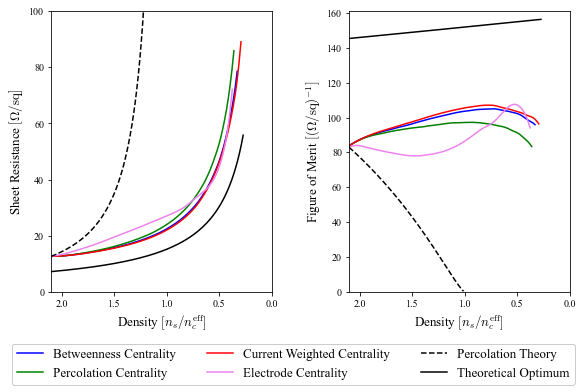

In [23]:

# setting text settings for matplotlib
plt.rcParams.update({
    'font.family' : 'Times New Roman',
#    'font.sans-serif' : ['Computer Modern Roman'],
    'mathtext.fontset' : 'cm'
})


#
fig, axsList = plt.subplots(
    figsize = (8,6),
    nrows = 1,
    ncols = 2
)
#fig = plt.figure(
#    figsize = (8, 5) # width, height in inches)
#)
#axsList = fig.subplots(1,2)
axs = {'resistance' : axsList[0],
       'fom' : axsList[1]}
# sorting evolvePlotData by centrality then by descending percMultiple
evolvePlotData.sort_values(by = ['centrality', 'percMultiple'],
                           ascending = [True, False],
                           inplace = True
                           )

evolvePlotData.to_csv(resultsFolder + 'evolvePlotData.csv',
                      index = False)

# capitalizing names:
for key, value in legendLabels.items():
    if 'centrality' in key:
        legendLabels[key] = ' '.join(
            [el.capitalize() for el in key.split('_')]
        )
# plotting the data on both subplots
for yKey, ax in axs.items():
    print('\n','remember y limits are hard coded in trajectory plot', '\n')
    if yKey == 'fom':
        ax.set_ylim(0,161)
    else:
        ax.set_ylim(0, 100)

    for c in legendLabels.keys():
        if c in skips:
            continue
        if yKey == 'fom':
            if c == 'opt' and False:
                continue
        #		if c != 'opt':
        #			continue
        df = evolvePlotData[evolvePlotData.centrality == c]
        ax.plot(df.percMultiple,
                df[yKey] ,#/ df[yKey].iloc[0],
                label = legendLabels[c],
                color = plotColors[c],
                linestyle = 'dashed' if c == 'Percolation Theory' else 'solid'
                )
    #		ax.legend(loc = 'upper left' if yKey == 'resistance' else 'lower right',
    #			framealpha = 0.9)
    ax.set_xlim(evolvePlotData.percMultiple.max(),0)
    ax.set_xlabel(r"Density $[n_s / n_c^\mathrm{eff}]$",
        fontsize = 13)
#	ax.set_yscale('log')



# setting y axis labels
#axs['resistance'].set_ylabel(r"Sheet Resistance $\displaystyle[\Omega / \text{sq}]$",
#                             fontsize = 'medium')
#axs['fom'].set_ylabel(r"FOM $\displaystyle\left[\frac{1}{\Omega / \text{sq}}\right]$",
#                      fontsize = 'medium')
#
axs['resistance'].set_ylabel(r"Sheet Resistance $\left[\Omega / \mathrm{sq}\right]$",
                             fontsize = 13
)

axs['fom'].set_ylabel(r"Figure of Merit $\left[\left(\Omega / \mathrm{sq}\right)^{-1}\right]$",
                      fontsize = 13)

plt.subplots_adjust(wspace = 0.35,
                    left = 0.08,
                    right = 0.98,
                    top = 0.88,
                    bottom = 0.23)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc = 'lower left',
           bbox_to_anchor = (0.00, 0.00, 1, 0.1), # specifies x,y, width, height of boudning box of legend
           # mesured from lower left corner because that's the position specified in loc
           mode = 'expand',
           framealpha = 1,
           fontsize = 13,
           ncol = 3)



plt.savefig(resultsFolder + 'FIG_4.pdf',
            pad_inches = 0)


### Version of plots for graphical abstract


 remember y limits are hard coded in trajectory plot 


 remember y limits are hard coded in trajectory plot 



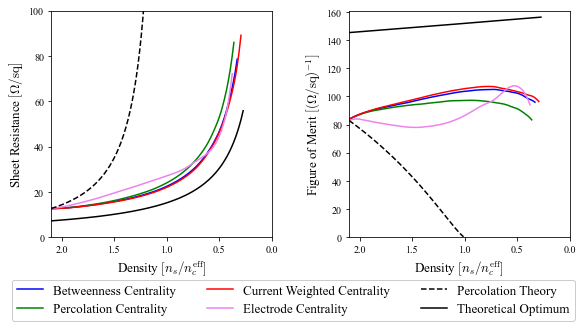

In [26]:
plt.close()

fig, axsList = plt.subplots(
    figsize = (8,5),
    nrows = 1,
    ncols = 2
)

axs = {'resistance' : axsList[0],
       'fom' : axsList[1]}
# plotting the data on both subplots
for yKey, ax in axs.items():
    print('\n','remember y limits are hard coded in trajectory plot', '\n')
    if yKey == 'fom':
        ax.set_ylim(0,161)
    else:
        ax.set_ylim(0, 100)

    for c in legendLabels.keys():
        if c in skips:
            continue
        if yKey == 'fom':
            if c == 'opt' and False:
                continue
        #		if c != 'opt':
        #			continue
        df = evolvePlotData[evolvePlotData.centrality == c]
        ax.plot(df.percMultiple,
                df[yKey] ,#/ df[yKey].iloc[0],
                label = legendLabels[c],
                color = plotColors[c],
                linestyle = 'dashed' if c == 'Percolation Theory' else 'solid'
                )
    #		ax.legend(loc = 'upper left' if yKey == 'resistance' else 'lower right',
    #			framealpha = 0.9)
    ax.set_xlim(evolvePlotData.percMultiple.max(),0)
    ax.set_xlabel(r"Density $[n_s / n_c^\mathrm{eff}]$",
        fontsize = 13)
#	ax.set_yscale('log')



# setting y axis labels
#axs['resistance'].set_ylabel(r"Sheet Resistance $\displaystyle[\Omega / \text{sq}]$",
#                             fontsize = 'medium')
#axs['fom'].set_ylabel(r"FOM $\displaystyle\left[\frac{1}{\Omega / \text{sq}}\right]$",
#                      fontsize = 'medium')
#
axs['resistance'].set_ylabel(r"Sheet Resistance $\left[\Omega / \mathrm{sq}\right]$",
                             fontsize = 13
)

axs['fom'].set_ylabel(r"Figure of Merit $\left[\left(\Omega / \mathrm{sq}\right)^{-1}\right]$",
                      fontsize = 13)

plt.subplots_adjust(wspace = 0.35,
                    left = 0.08,
                    right = 0.98,
                    top = 0.88,
                    bottom = 0.25)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc = 'lower left',
           bbox_to_anchor = (0.00, 0.00, 1, 0.1), # specifies x,y, width, height of boudning box of legend
           # mesured from lower left corner because that's the position specified in loc
           mode = 'expand',
           framealpha = 1,
           fontsize = 13,
           ncol = 3)



plt.savefig(resultsFolder + 'FIG4_Graphical_Abstract_Plot.pdf',
            pad_inches = 0)


7.241742892015825 89.07881983923573


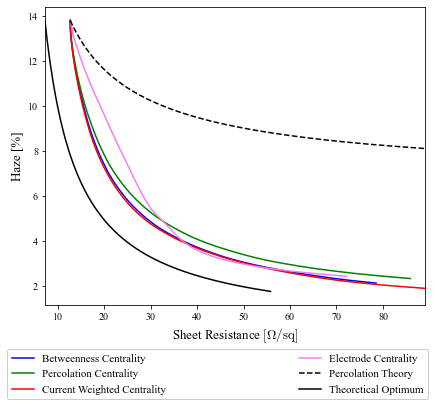

In [13]:
# plotting haze
fig, ax = plt.subplots(
    figsize = (6,6),
)

for c in legendLabels.keys():
    df = evolvePlotData[evolvePlotData.centrality == c]
    ax.plot(df.resistance,
            100 * df.haze,# converting haze to percentage
            label = legendLabels[c],
            color = plotColors[c],
            linestyle = 'dashed' if c == 'Percolation Theory' else 'solid'
            )
#finding the bound of the graph which should be the bound of the data sets we are using
# and also excluding the percolation theory data
evolvePlotData['skip'] = evolvePlotData.centrality.apply(lambda x : x in skips)
df = evolvePlotData[ (evolvePlotData.skip == False) & (evolvePlotData.centrality != 'Percolation Theory')]
resMin = df.resistance.min()
resMax = df.resistance.max()
ax.set_xlim(resMin, resMax)
print(resMin, resMax)
ax.set_xlabel(r"Sheet Resistance $[\Omega / \mathrm{sq}]$",
                             fontsize = 13)



ax.set_ylabel(r"Haze [%]",
                      fontsize = 13)

plt.subplots_adjust(wspace = 0.35,
                    left = 0.1,
                    right = 0.98,
                    top = 0.92,
                    bottom = 0.23)

handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles,
#           labels,
#           loc = 'lower left',
#           bbox_to_anchor = (0.08, 0.88, 0.9, 0.1), # specifies x,y, width, height of boudning box of legend
#           # mesured from lower left corner because that's the position specified in loc
#           mode = 'expand',
#           framealpha = 1,
#           ncol = 2)
fig.legend(handles,
           labels,
           loc = 'lower left',
           bbox_to_anchor = (0.00, 0.00, 1, 0.1), # specifies x,y, width, height of boudning box of legend
           # mesured from lower left corner because that's the position specified in loc
           mode = 'expand',
           framealpha = 1,
           fontsize = 11,
           ncol = 2)



plt.savefig(resultsFolder + 'evolution_haze.pdf',
            pad_inches = 0)

In [14]:
df = evolvePlotData[ (evolvePlotData.skip == False)]

def density_interps(df, pm):
	vals = []
	for centrality in df.centrality.unique():
		idf = df[df.centrality == centrality]
		res = interpolate.interp1d(
			x = idf.percMultiple,
			y = idf.resistance
		)(pm)
		haze = interpolate.interp1d(
			x = idf.percMultiple,
			y = idf.haze
		)(pm)
		vals.append({
			'centrality' : centrality,
			'percMultiple' : pm,
			'resistance' : res,
			'haze' : haze
		})
	vals = pd.DataFrame(vals)
	return vals.sort_values('resistance')

density_interps(df, 1.5)

,centrality,percMultiple,resistance,haze
4,opt,1.5,10.143858115501981,0.09809581733538135
2,current_weighted_centrality,1.5,15.609524114732336,0.09809616367076492
1,betweenness_centrality,1.5,15.797054297665248,0.09809617379455512
5,percolation_centrality,1.5,16.211793140837454,0.09809616894840742
3,electrode_centrality,1.5,19.56374347052089,0.09809626814868032
0,Percolation Theory,1.5,35.10687993299997,0.09809582417876693


In [15]:
df.groupby('centrality').agg('min')

,percMultiple,resistance,resistanceSEM,transparency,fom,fomSEM,haze,resistanceRelativeSEM,fomRelativeSEM,density,skip
centrality,,,,,,,,,,,
Percolation Theory,1.010000,12.679629,NaN,0.719251,0.418969,NaN,0.065738,NaN,NaN,5.850183e+10,False
betweenness_centrality,0.329750,12.68847,0.090171,0.719275,83.776338,0.565358,0.02129,0.005935,0.005783,NaN,False
current_weighted_centrality,0.293495,12.689597,0.090406,0.719275,83.768056,0.564914,0.01894,0.005807,0.005628,NaN,False
electrode_centrality,0.376364,12.823288,0.088453,0.719288,78.022197,0.520029,0.024314,0.006213,0.006123,NaN,False
opt,0.272778,7.241742892015825,NaN,NaN,145.31651741226025,NaN,0.017597632225039524,NaN,NaN,NaN,False
percolation_centrality,0.360826,12.691264,0.090687,0.719275,83.369342,0.565048,0.023306,0.006733,0.006428,NaN,False


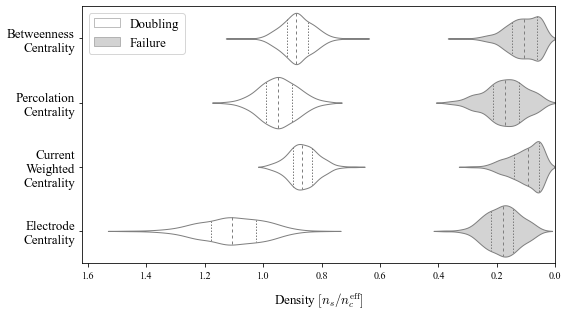

In [16]:

# saving trial stats to csv
trialStats.to_csv(resultsFolder + 'trialStats.csv', index = False)


#reshaping the data to be easy for seaborn to handle
violinData = trialStats.melt(id_vars = 'centrality', value_vars = ['failure density', 'doubling density'],
                             value_name = 'density',
                             var_name = 'type')

#filtering out the data we want to skip
for centrality in skips:
    violinData = violinData[violinData.centrality != centrality]

violinLegendLabels = {
    'betweenness_centrality' : r"$C_B$",
    'unweighted_betweenness_centrality' : r"$C_{\mathrm{uw}}$",
    'percolation_centrality' : r"$C_{\mathrm{perc}}$",
    'current_weighted_centrality' : r"$C_\mathrm{curr}$",
    'electrode_centrality' : r"$C_{\mathrm{elec}}$",
    'power_weighted_centrality' : r"$C_{\mathrm{pow}}$",
    'Percolation Theory' : 'Percolation Theory',
    'random_cleaned' : "RAND",
    'random' : 'RAND UNCLEANED',
    'opt' : 'Theoretical Optimum'
}

violinLegendLabels = {
    'betweenness_centrality' : r"Betweenness Centrality",
    'unweighted_betweenness_centrality' : r"Unweighted Betweenness Centrality",
    'percolation_centrality' : r"Percolation Centrality",
    'current_weighted_centrality' : r"Current Weighted Centrality",
    'electrode_centrality' : r"Electrode Centrality",
    'power_weighted_centrality' : r"Power Weighted Centrality",
    'Percolation Theory' : 'Percolation Theory',
    'random_cleaned' : "RAND",
    'random' : 'RAND UNCLEANED',
    'opt' : 'Theoretical Optimum'
}

for key,value in violinLegendLabels.items():
    violinLegendLabels[key] = '\n'.join(value.split(' '))


violinData['centrality'] = violinData.apply(lambda x : violinLegendLabels[x.centrality], axis = 1)
#violinData['centrality'] = violinData.apply(lambda x : x.centrality.replace(' ','\n'), axis = 1)
violinData['type'] = violinData.apply(lambda x : x['type'].capitalize().replace(' density', ''), axis = 1)

# changing the violinData to have the centralities in the same order as in legendLabels
# which is how the order in the other plot is et
centralityOrder = {centrality : n for n, centrality in enumerate(violinLegendLabels.values())}
violinData['order'] = violinData.apply(lambda x : centralityOrder[x.centrality], axis = 1)
violinData.sort_values(by = ['order', 'type'],
                       ascending = [True, True],
                       inplace = True)

fig = plt.figure(figsize = (8, 4.5))
ax = sns.violinplot(data = violinData,
                    x = 'density',
                    y = 'centrality',
                    hue = 'type',
                    #			split = True,
                    dodge = False,
                    inner = 'quartile',
                    linewidth = 1,
                    palette = {'Doubling' : 'white', 'Failure': 'lightgray'})
ax.set_xlim(1.62,0)
#ax.set_ylabel('Centrality', labelpad = 10,
#              fontsize = 'medium')
ax.set_ylabel('')
ax.set_xlabel(r"Density $[n_s / n_{c}^{\mathrm{eff}}]$",
              fontsize = 13,
              labelpad = 10)
ax.legend(title = None,
          fontsize = 13,
          loc = 2) # setting location to be upper left
ax.set_yticklabels(ax.get_yticklabels(),fontsize = 13)

fig.tight_layout() 

plt.savefig(resultsFolder + 'FIG_5.pdf', pad_inches = 0)



In [17]:

# # making violin plot for presentation
# fig = plt.figure(figsize = (8,4.5))
# ax = sns.violinplot(data = violinData,
#                     x = 'density',
#                     y = 'centrality',
#                     hue = 'type',
#                     split = True,
#                     inner = 'quartile',
#                     linewidth = 1)
# #palette = {'Doubling' : 'white', 'Failure': 'lightgray'})
# #ax.set_xlim(1.5,0)
# ax.set_ylabel('Centrality', labelpad = 10,
#               fontsize = 'medium')
# ax.set_title('Failure and Doubling Distributions',
#              fontsize = 'large',
#              pad = 10)
# ax.set_xlabel(r"Density $[n_s / n_c^\mathrm{eff}]$",
#               fontsize = 'medium',
#               labelpad = 10)
# ax.legend(title = None,
#           fontsize = 'small',
#           loc = 2) # setting location to be upper left
# fig.tight_layout()

# plt.savefig(resultsFolder + 'trialStats_v3_MRS_presentation.pdf', pad_inches = 0)


# medianFailure = violinData[violinData.type == 'Failure']['density'].median()
# print('median failure density is', medianFailure)




# evolvePlotData.to_csv(resultsFolder + 'evolvePlotData.csv', index = False)

# # testing some shit
# print('testing some shit')
# plt.close()

# evolvePlotData['scaled fom'] = evolvePlotData.apply(
#     lambda x : x.fom / theoreticalOptInterp['fom'](x.percMultiple),
#     axis = 1)

# evolvePlotData['centrality']  = evolvePlotData.apply(
#     lambda x : x.centrality.replace('_',' '),
#     axis = 1)

# ax = sns.lineplot(
#     data = evolvePlotData[evolvePlotData.centrality != 'opt'],
#     x = 'percMultiple',
#     y = 'scaled fom',
#     hue = 'centrality')

# print('Random numbers that are important for the paper')

# print('Best FOMs of each method')
# bestFoms = []
# for c in evolvePlotData.centrality.unique():
#     bdf = evolvePlotData[evolvePlotData.centrality == c]
#     #making sure that the first row of the bdf is also the row at the starting density
#     assert bdf['percMultiple'].iloc[0] == bdf['percMultiple'].max(), 'cannot get starting fom from first row'

#     bestFomRow = np.argmax(bdf.fom)
#     rowData = bdf.iloc[bestFomRow, :]
#     bestFoms.append({'centrality' : rowData['centrality'],
#                      'percMultiple' : rowData['percMultiple'],
#                      'bestFom' : rowData['fom'],
#                      'startFom' : bdf['fom'].iloc[0],
#                      'fomImprovement' : (rowData['fom'] - bdf['fom'].iloc[0]) / bdf['fom'].iloc[0]
#                      }
#                     )

# bestFoms = pd.DataFrame(bestFoms)
# # calculating percent of optimal (and rounding stuff)
# bestFoms['bestFom'] = bestFoms.apply(
#     lambda x : np.round(x.bestFom, 6),
#     axis = 1)

# bestFoms['bestFom % Opt'] = bestFoms.apply(
#     lambda x : x.bestFom / theoreticalOptInterp['fom'](x.percMultiple),
#     axis = 1)

# bestFoms.sort_values(by = 'bestFom',
#                      ascending = False,
#                      inplace = True)



# print(bestFoms)

# pdb.set_trace()

